In [24]:
# Split into 5000 tick images with 1000 tick shift
import mido
from utils import mido_setup, get_track_instrument_type
import os
import pandas
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
initial_path = "/Users/edlgg/repos/dissertation/midis/clean_songs_0_vels/"
images_path = "/Users/edlgg/repos/dissertation/images/v1"
images_out_path = "/Users/edlgg/repos/dissertation/results/images/v1"
midi_out_path = "/Users/edlgg/repos/dissertation/results/midis/v1"

In [6]:
mid = mido.MidiFile(path + "Erin_Shore.mid")

In [7]:
mid.tracks[0][1]

<message note_on channel=4 note=50 velocity=108 time=12157>

<message note_on channel=0 note=62 velocity=80 time=597>

note_on channel=7 note=59 velocity=60 time=14464
note_on channel=7 note=59 velocity=0 time=32
note_on channel=7 note=59 velocity=79 time=18
note_on channel=7 note=59 velocity=0 time=42
note_on channel=7 note=61 velocity=82 time=10
note_on channel=7 note=61 velocity=0 time=30
note_on channel=7 note=61 velocity=95 time=7
note_on channel=7 note=61 velocity=0 time=45
note_on channel=7 note=59 velocity=47 time=8
note_on channel=7 note=61 velocity=55 time=53
note_on channel=7 note=59 velocity=0 time=3
note_on channel=7 note=61 velocity=0 time=32
note_on channel=7 note=64 velocity=86 time=6
note_on channel=7 note=64 velocity=0 time=54
note_on channel=7 note=66 velocity=93 time=42
note_on channel=7 note=66 velocity=0 time=59
note_on channel=7 note=67 velocity=95 time=41
note_on channel=7 note=68 velocity=46 time=11
note_on channel=7 note=67 velocity=0 time=11
note_on channel=7 note=68 velocity=0 time=45
note_on channel=7 note=63 velocity=95 time=72
note_on channel=7 note=63 velocity=0 time=43


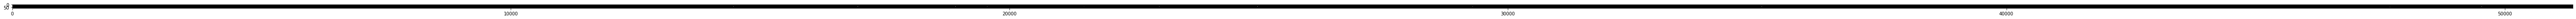

In [40]:
def track_to_image(track, length):
    time_step = 0
    image = [ [-1]*length for _ in range(70) ]
    for msg in track:
        if msg.type == "note_on":
            time_step = time_step + msg.time
            image[msg.note-20][time_step] = msg.velocity
            print(msg)
    return image

def test_track_to_image(initial_path):
    song = mido.MidiFile(initial_path + "american_hiway40blues.mid")
    track = song.tracks[0]
    le = 1
    for msg in track:
        if msg.type == "note_on":
            le = le + msg.time
    image = track_to_image(track, le)
    x = [row[:500] for row in image]
    plt.figure(figsize=(100,300))
    plt.imshow(image, cmap='gray', interpolation='nearest', vmin=0, vmax=120)
    plt.show()
test_track_to_image(initial_path)

In [10]:
def create_image_from_mid(mid):
    guitar_image = create_image_from_track(mid.tracks[0])
    bass_image = create_image_from_track(mid.tracks[1])
    # combine ima
    pass

In [11]:
def split_image(image, size, stride):
    pass

In [13]:
def create_images(initial_path, end_path):
    pass

In [14]:
def create_midi_from_image(image):
    pass

In [ ]:
def create_midis(images_path, midi_out_path):